Exception ignored in: <function _xla_gc_callback at 0x7f837568ddc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


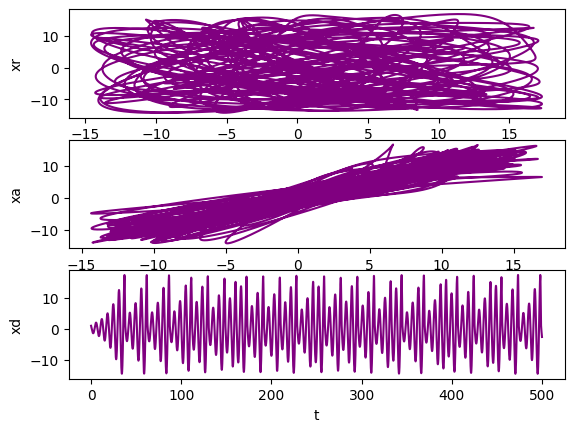

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

a = 0.15;
p = 0.2;
c = 10.0;
wr = 0.95;
wd = 0.99;
e = 0.03;

def rossler(H, t=0):
    return np.array([(-wd*H[1])-H[2], #xd 0
                    (wd*H[0])+(a*H[1]), #yd 1
                    p+(H[2]*(H[0]-c)), #zd 2 
                    ((-wr*H[4])-H[5])+e*(H[0]-H[3]), #xr 3
                    (wr*H[3])+(a*H[4]), #yr 4 
                    p+(H[5]*(H[3]-c)), #zr 5
                    (((-wr*H[7])-H[8])+e*(H[0]-H[6])), #xa 6
                    ((wr*H[6])+(a*H[7])), #ya 7 
                    p+(H[8]*(H[6]-c))]) #za 8 
                    

T = 1000000; T0 = 400000;
t = np.linspace(0, 500, T)
#t = np.linspace(0, T/2, T)
#t = np.arange(0.1, 10000, 0.01)
#T0 = 920000


#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.1, 0.1, 0.1]
H0 = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.05, 1.05, 1.05 ]
#H0 = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001,]
H, infodict = integrate.odeint(rossler, H0, t, full_output=True)

fig, axs = plt.subplots(3)
axs[0].plot(H[T0:,0],H[T0:,3],c='purple') #xd xr
axs[1].plot(H[T0:,3],H[T0:,6],c='purple') #xr,xa
axs[2].plot(t,H[:,0],c='purple')

#plt.plot(H[:,3],H[:,6],c='purple') #xr,xa
#plt.plot(H[1000:,0],H[1000:,3],c='purple')
plt.setp(axs[0], xlabel='xd')
plt.setp(axs[0], ylabel='xr')
plt.setp(axs[1], xlabel='xr')
plt.setp(axs[1], ylabel='xa')
plt.setp(axs[2], xlabel='t')
plt.setp(axs[2], ylabel='xd')
plt.show()
#v = np.array(np.meshgrid(H[T0:,0], H[T0:,3])).T.reshape(-1, 2)
#v = np.array(np.meshgrid(H[T0:,3], t[T0:])).T.reshape(-1, 2)
#print(t[T0:])
#np.savetxt('xt.csv', v, delimiter=",")

#print(len(H[T0:,0]))







In [ ]:
q = np.vstack((H[T0:,3],t[T0:])).T
df = pd.DataFrame(q, columns = ['x','t'])

df1 = pd.DataFrame(H[T0:,3])
print(df)
print(df1)

               x         t
0       4.490463  200.0002
1       4.485550  200.0007
2       4.480636  200.0012
3       4.475721  200.0017
4       4.470806  200.0022
...          ...       ...
599995  8.909879  499.9980
599996  8.905254  499.9985
599997  8.900628  499.9990
599998  8.896000  499.9995
599999  8.891369  500.0000

[600000 rows x 2 columns]
               0
0       4.490463
1       4.485550
2       4.480636
3       4.475721
4       4.470806
...          ...
599995  8.909879
599996  8.905254
599997  8.900628
599998  8.896000
599999  8.891369

[600000 rows x 1 columns]


<Axes: xlabel='t', ylabel='x'>

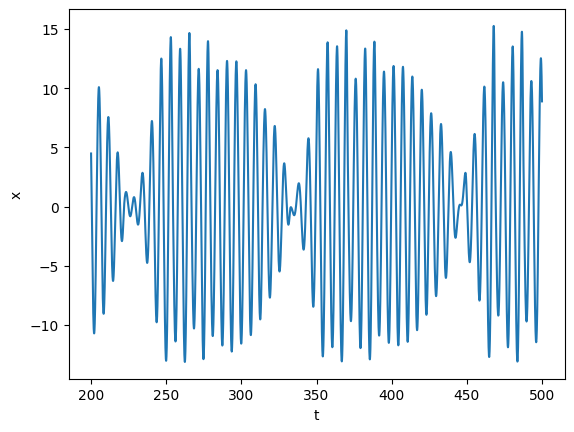

In [ ]:
sns.lineplot(x='t', y='x', data=df)

<Axes: >

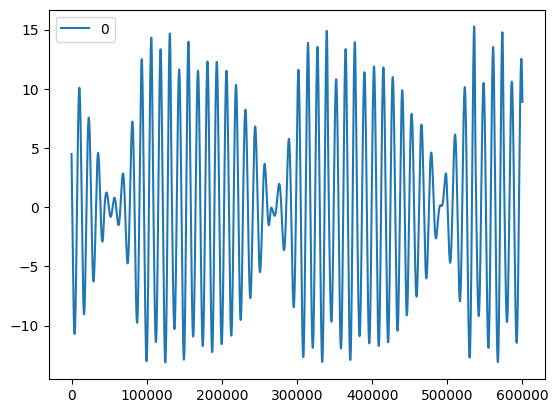

In [ ]:
df1.plot()

In [ ]:
t1 = t[T0:]
print(t1)

[200.0002 200.0007 200.0012 ... 499.999  499.9995 500.    ]


In [ ]:
def df_to_X_y(df,t, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row=[a for a in df_as_np[i:i+5]]
    X.append(row)
    label=df_as_np[i+5]
    y.append(label)
  return np.array(X),np.array(y)

In [ ]:
WINDOW_SIZE = 5
X,y = df_to_X_y(df1,t1,WINDOW_SIZE)
X.shape, y.shape

((599995, 5, 1), (599995, 1))

In [ ]:
y=y.flatten()

In [ ]:
X_train, y_train = X[:500000], y[:500000]
X_val, y_val = X[500000:550000], y[500000:550000]
X_test, y_test = X[550000:], y[550000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((500000, 5, 1), (500000,), (50000, 5, 1), (50000,), (49995, 5, 1), (49995,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
15624/15625 [============================>.] - ETA: 0s - loss: 0.9579 - root_mean_squared_error: 0.9787

15625/15625 [==============================] - 102s 6ms/step - loss: 0.9579 - root_mean_squared_error: 0.9787 - val_loss: 3.1019e-04 - val_root_mean_squared_error: 0.0176
Epoch 2/10
15617/15625 [============================>.] - ETA: 0s - loss: 7.3933e-05 - root_mean_squared_error: 0.0086

15625/15625 [==============================] - 97s 6ms/step - loss: 7.3921e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.3607e-04 - val_root_mean_squared_error: 0.0117
Epoch 3/10
15621/15625 [============================>.] - ETA: 0s - loss: 6.0609e-05 - root_mean_squared_error: 0.0078

15625/15625 [==============================] - 98s 6ms/step - loss: 6.0603e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.0132e-04 - val_root_mean_squared_error: 0.0101
Epoch 4/10
15622/15625 [============================>.] - ETA: 0s - loss: 5.1507e-05 - root_mean_squared_error: 0.0072

15625/15625 [==============================] - 96s 6ms/step - loss: 5.1502e-05 - root_mean_squared_error: 0.0072 - val_loss: 8.8090e-05 - val_root_mean_squared_error: 0.0094
Epoch 5/10
15623/15625 [============================>.] - ETA: 0s - loss: 4.4298e-05 - root_mean_squared_error: 0.0067

15625/15625 [==============================] - 96s 6ms/step - loss: 4.4307e-05 - root_mean_squared_error: 0.0067 - val_loss: 6.0997e-05 - val_root_mean_squared_error: 0.0078
Epoch 6/10
15624/15625 [============================>.] - ETA: 0s - loss: 3.7829e-05 - root_mean_squared_error: 0.0062

15625/15625 [==============================] - 92s 6ms/step - loss: 3.7835e-05 - root_mean_squared_error: 0.0062 - val_loss: 5.7747e-05 - val_root_mean_squared_error: 0.0076
Epoch 7/10
15622/15625 [============================>.] - ETA: 0s - loss: 3.2598e-05 - root_mean_squared_error: 0.0057

15625/15625 [==============================] - 96s 6ms/step - loss: 3.2596e-05 - root_mean_squared_error: 0.0057 - val_loss: 4.2656e-05 - val_root_mean_squared_error: 0.0065
Epoch 8/10
15625/15625 [==============================] - 94s 6ms/step - loss: 3.0262e-05 - root_mean_squared_error: 0.0055 - val_loss: 4.5677e-05 - val_root_mean_squared_error: 0.0068
Epoch 9/10
15625/15625 [==============================] - 91s 6ms/step - loss: 2.6075e-05 - root_mean_squared_error: 0.0051 - val_loss: 4.9676e-05 - val_root_mean_squared_error: 0.0070
Epoch 10/10
15625/15625 [==============================] - 91s 6ms/step - loss: 2.3980e-05 - root_mean_squared_error: 0.0049 - val_loss: 6.3461e-05 - val_root_mean_squared_error: 0.0080


In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [ ]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

15625/15625 [==============================] - 52s 3ms/step


,Train Predictions,Actuals
0,4.465175,4.465889
1,4.460258,4.460972
2,4.455339,4.456053
3,4.450421,4.451134
4,4.445501,4.446214
...,...,...
499995,0.797324,0.796710
499996,0.795479,0.794866
499997,0.793634,0.793022
499998,0.791789,0.791178


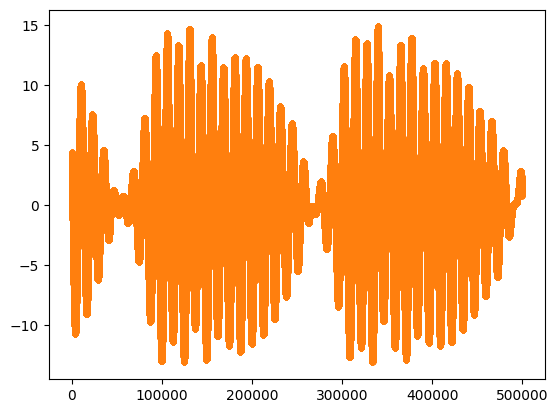

In [ ]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'],'.')

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

1563/1563 [==============================] - 5s 3ms/step


,Val Predictions,Actuals
0,0.788098,0.787488
1,0.786251,0.785642
2,0.784405,0.783797
3,0.782557,0.781950
4,0.780710,0.780104
...,...,...
49995,6.878342,6.877806
49996,6.874387,6.873853
49997,6.870430,6.869898
49998,6.866471,6.865942


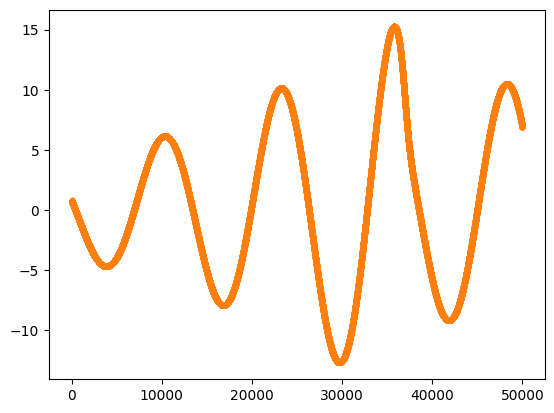

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'],'.')

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})
test_results


1563/1563 [==============================] - 5s 3ms/step


,test Predictions,Actuals
0,6.858546,6.858024
1,6.854581,6.854063
2,6.850615,6.850099
3,6.846646,6.846135
4,6.842678,6.842168
...,...,...
49990,8.914837,8.909879
49991,8.910209,8.905254
49992,8.905577,8.900628
49993,8.900944,8.896000


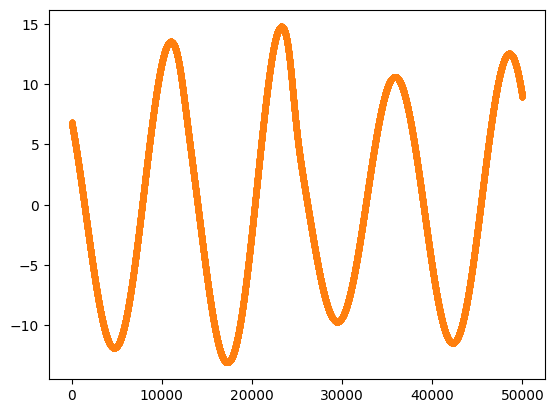

In [ ]:
plt.plot(test_results['test Predictions'])
plt.plot(test_results['Actuals'],'.')

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'])
  plt.plot(df['Actuals'])
  return df, mse(y, predictions)

1563/1563 [==============================] - 5s 3ms/step


(       Predictions   Actuals
 0         6.858546  6.858024
 1         6.854581  6.854063
 2         6.850615  6.850099
 3         6.846646  6.846135
 4         6.842678  6.842168
 ...            ...       ...
 49990     8.914837  8.909879
 49991     8.910209  8.905254
 49992     8.905577  8.900628
 49993     8.900944  8.896000
 49994     8.896308  8.891369
 
 [49995 rows x 2 columns],
 2.8091149271603615e-05)

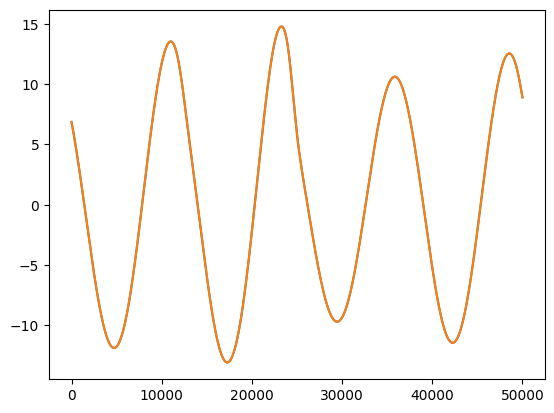

In [ ]:
plot_predictions1(model1, X_test, y_test)

In [ ]:
pred = model1.predict(X_test)
pred = pd.DataFrame(pred)
pred.to_csv(f"test_out2.csv",index=False,header=None)

1563/1563 [==============================] - 5s 3ms/step


In [ ]:
pred1 = model1.predict(X_train)
pred1 = pd.DataFrame(pred1)
pred1.to_csv(f"test_out_train2_new.csv",index=False,header=None)

15625/15625 [==============================] - 51s 3ms/step
